#### Introduction

Thus far previous Yolo implementations were based on cnns because attention mechanism wasn't efficient.

This paper introduces 3 major improvements:


### 1. Area attention module

### 2. R-Elan 
### 3.General improvements
    3.1 introducing Flash-attention
    3.2 Adjusting the Mlp ratio from 4 to 1.2
    3.3 Reducing the depths of the stacked blocks for optimization
    3.4 Using conv as much as possible

### Approach

##### Efficiency analysis

Computational complexityy of the self attetion scales quadratically with the input sequence length L for dimension d complexity becomes 

$ O(L^2d) $

But for CNN with kernel size k which is usually much smaller than L   complexity becomes 

$O(kLd)$

Also with the extra modules like posional encoding computation takes much more time.


##### Computation 

During self attention attention map and softmax map also takes extra memory and irregular memory access in attention mechanism introduces further latency.




### Flash attention

Flash attention is a new attention mechanism that is faster and more memory efficient than the traditional attention mechanism.



In [1]:
def flash_attn_func(q,k,v):
    pass






### Area Attention 

Instead of using linear attention paper suggests using area attention.Image wirth the resolution (H,W) is divided into non-overlapping areas with the size of (H/L,W) or (H,W/L).

Even though complexity only reduces from $2n^2 hd$ to $(1/2)n^2 hd$ it is efficient enough for real time applications.










In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class AAttn(nn.Module):
    """
    Area-attention module with the requirement of flash attention.

    Attributes:
        dim (int): Number of hidden channels;
        num_heads (int): Number of heads into which the attention mechanism is divided;
        area (int, optional): Number of areas the feature map is divided. Defaults to 1.

    Methods:
        forward: Performs a forward process of input tensor and outputs a tensor after the execution of the area attention mechanism.

    Examples:
        >>> import torch
        >>> from ultralytics.nn.modules import AAttn
        >>> model = AAttn(dim=64, num_heads=2, area=4)
        >>> x = torch.randn(2, 64, 128, 128)
        >>> output = model(x)
        >>> print(output.shape)
    
    Notes: 
        recommend that dim//num_heads be a multiple of 32 or 64.

    """

    def Conv(self, dim, out_dim, k, s, p, g, act=True):
        pass
    def __init__(self, dim, num_heads, area=1):
        """Initializes the area-attention module, a simple yet efficient attention module for YOLO."""
        super().__init__()
        self.area = area

        self.num_heads = num_heads
        self.head_dim = head_dim = dim // num_heads
        all_head_dim = head_dim * self.num_heads

        self.qk = Conv(dim, all_head_dim * 2, 1, act=False)
        self.v = Conv(dim, all_head_dim, 1, act=False)
        self.proj = Conv(all_head_dim, dim, 1, act=False)

        self.pe = Conv(all_head_dim, dim, 5, 1, 2, g=dim, act=False)


    def forward(self, x):
        """Processes the input tensor 'x' through the area-attention"""
        B, C, H, W = x.shape
        N = H * W

        qk = self.qk(x).flatten(2).transpose(1, 2)
        v = self.v(x)
        pp = self.pe(v)
        v = v.flatten(2).transpose(1, 2)

        if self.area > 1:
            qk = qk.reshape(B * self.area, N // self.area, C * 2)
            v = v.reshape(B * self.area, N // self.area, C)
            B, N, _ = qk.shape
        q, k = qk.split([C, C], dim=2)

        if x.is_cuda :
            q = q.view(B, N, self.num_heads, self.head_dim)
            k = k.view(B, N, self.num_heads, self.head_dim)
            v = v.view(B, N, self.num_heads, self.head_dim)

            x = flash_attn_func(
                q.contiguous().half(),
                k.contiguous().half(),
                v.contiguous().half()
            ).to(q.dtype)
        else:
            q = q.transpose(1, 2).view(B, self.num_heads, self.head_dim, N)
            k = k.transpose(1, 2).view(B, self.num_heads, self.head_dim, N)
            v = v.transpose(1, 2).view(B, self.num_heads, self.head_dim, N)

            attn = (q.transpose(-2, -1) @ k) * (self.head_dim ** -0.5)
            max_attn = attn.max(dim=-1, keepdim=True).values
            exp_attn = torch.exp(attn - max_attn)
            attn = exp_attn / exp_attn.sum(dim=-1, keepdim=True)
            x = (v @ attn.transpose(-2, -1))

            x = x.permute(0, 3, 1, 2)

        if self.area > 1:
            x = x.reshape(B // self.area, N * self.area, C)
            B, N, _ = x.shape
        x = x.reshape(B, H, W, C).permute(0, 3, 1, 2)

        return self.proj(x + pp)

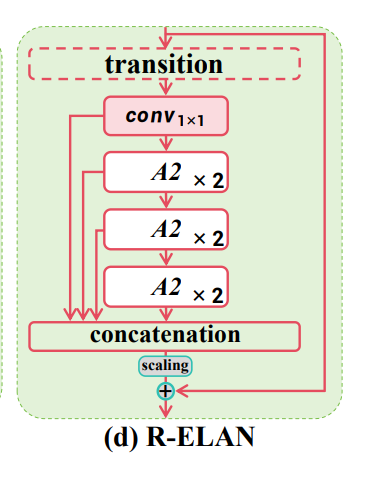

In [3]:
from IPython.display import Image
Image(filename='notebook_images/Relan.png')


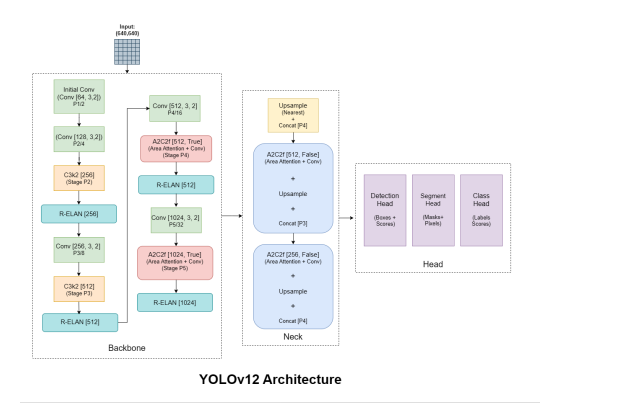

In [6]:
from IPython.display import Image
Image(filename='notebook_images/Yolov12architecture.png')

##### Demo

In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO12n model
model = YOLO("yolo12n.pt")

# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data="coco8.yaml", epochs=100, imgsz=640)



In [ ]:
# Run inference with the YOLO12n model on the 'bus.jpg' image
results = model("notebook_images/bus.png")

# Plot the results
import cv2

img = results[0].plot()
cv2.imshow('YOLO Detection Results', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()

